<a href="https://colab.research.google.com/github/shizoda/education/blob/main/machine_learning/unet/unet_lung_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CT 像からの肺がん領域抽出（セグメンテーション）

このノートブックでは、医療画像処理において一般的なU-Netアーキテクチャを使用して、肺がん領域の抽出を行います。U-Netはその精度と効率性で知られており、特にセグメンテーションタスクにおいて優れた性能を発揮します。ここでは、ステップバイステップでU-Netモデルの構築からトレーニング、評価までを行い、肺のCT画像から肺がん領域を抽出する方法を紹介します。


## データの読み込み

このセクションでは、肺のCT画像とそれに対応するラベル（癌の有無）を読み込みます。GitHub にアップロードされているデータを Google ドライブにダウンロードます。

続けて、PyTorch の Tensor に変換し、DataLoader を作成します。ミニバッチサイズもここで設定しています。

In [2]:
# Google Driveがマウントされているか確認し、されていなければマウント
from google.colab import drive
import os
if not os.path.exists('/content/drive/MyDrive'):
    drive.mount('/content/drive/')

In [3]:
import os
import gdown
# ディレクトリの作成
directory = '/content/drive/MyDrive/education/data/msd/lung_2mm/'
os.makedirs(directory + "nii/", exist_ok=True)

# GitHubからファイルをダウンロードする
base_url = 'https://github.com/shizoda/data/raw/main/msd/lung_2mm/'
file_names = ['train_patches.h5', 'val_patches.h5', 'test_patches.h5', 'nii/lung_001.nii.gz', 'nii/lung_009.nii.gz', 'nii/lung_016.nii.gz']

for file_name in file_names:
    url = base_url + file_name
    output = directory + file_name
    if not os.path.exists(output):  # すでにファイルが存在しない場合にのみダウンロード
        gdown.download(url, output, quiet=False)

In [4]:
# 各種ライブラリのインポート
import numpy as np
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
import torch.nn.functional as F

In [5]:
def load_data(h5_file):
    # HDF5ファイルから画像とラベルを読み込む関数
    with h5py.File(h5_file, 'r') as h5f:
        images = h5f['images'][:]
        labels = h5f['labels'][:]
    return images, labels

# データ（HDF5 ファイル、拡張子 .h5 ）の読み込みと準備
train_images, train_labels = load_data('/content/drive/MyDrive/education/data/msd/lung_2mm/train_patches.h5')
val_images, val_labels = load_data('/content/drive/MyDrive/education/data/msd/lung_2mm/val_patches.h5')
test_images, test_labels = load_data('/content/drive/MyDrive/education/data/msd/lung_2mm/test_patches.h5')

# PyTorchのTensorに変換
train_dataset = TensorDataset(torch.tensor(train_images, dtype=torch.float32), torch.tensor(train_labels, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(val_images, dtype=torch.float32), torch.tensor(val_labels, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(test_images, dtype=torch.float32), torch.tensor(test_labels, dtype=torch.float32))

# DataLoaderの設定
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)


## U-Netモデルの構築

ここでは、U-Netのアーキテクチャを構築します。U-Netは「U」字型の構造を持つネットワークで、特に医用画像処理でのセグメンテーションにおいて広く用いられています。
https://www.skillupai.com/blog/tech/segmentation2

以下の実装は、原論文 [Ronnerberger, 2015](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/) とは細部が異なる点には留意してください。

In [6]:
# U-Net の実装
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # 初期チャネル数
        self.base_channels = 16

        # Encoder（ダウンサンプリング）
        self.enc_conv1 = nn.Conv2d(1, self.base_channels, kernel_size=3, padding=1)
        self.enc_conv2 = nn.Conv2d(self.base_channels, self.base_channels * 2, kernel_size=3, padding=1)
        self.enc_conv3 = nn.Conv2d(self.base_channels * 2, self.base_channels * 4, kernel_size=3, padding=1)

        # Max Pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Decoder（アップサンプリング）
        self.dec_upconv3 = nn.ConvTranspose2d(self.base_channels * 4, self.base_channels * 2, kernel_size=2, stride=2)
        self.dec_conv3 = nn.Conv2d(self.base_channels * 4, self.base_channels * 2, kernel_size=3, padding=1)
        self.dec_upconv2 = nn.ConvTranspose2d(self.base_channels * 2, self.base_channels, kernel_size=2, stride=2)
        self.dec_conv2 = nn.Conv2d(self.base_channels * 2, self.base_channels, kernel_size=3, padding=1)

        # Final Layer
        self.final_conv = nn.Conv2d(self.base_channels, 1, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc1 = F.relu(self.enc_conv1(x))
        enc2 = F.relu(self.enc_conv2(self.pool(enc1)))
        enc3 = F.relu(self.enc_conv3(self.pool(enc2)))

        # Decoder
        dec3 = torch.cat((F.relu(self.dec_upconv3(enc3)), enc2), dim=1)
        dec3 = F.relu(self.dec_conv3(dec3))
        dec2 = torch.cat((F.relu(self.dec_upconv2(dec3)), enc1), dim=1)
        dec2 = F.relu(self.dec_conv2(dec2))

        # Final segmented output
        out = torch.sigmoid(self.final_conv(dec2))
        return out

## 学習の準備

損失関数、最適化手法、各種ハイパーパラメータを設定します。

### 損失関数 Dice Loss

とりわけ医用画像では、クラス間のインバランス（前景と背景の大きさの差）が問題となりやすいことが知られています。今回は、抽出精度の評価にも用いられる Dice 係数
- https://mieruca-ai.com/ai/jaccard_dice_simpson/

を基にした Dice Loss という損失関数を用いることで、その問題の影響を受けにくくしています。
- https://knowwell-livewell.hatenablog.com/entry/2022/01/31/150552

### オプティマイザ Adam

Adam は初心者にも理解しやすく、多くの異なる種類のディープラーニングモデルでうまく機能することが知られています、Adamは学習率（モデルがデータから学ぶ速さ）を自動で調整する機能をもっており、モデルの学習プロセスがスムーズになります。

- https://qiita.com/omiita/items/1735c1d048fe5f611f80
- https://rightcode.co.jp/blog/information-technology/torch-optim-optimizer-compare-and-verify-update-process-and-performance-of-optimization-methods

In [7]:
# モデル、オプティマイザー、損失関数の定義
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        # Flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)

        return 1 - dice

# 損失関数 Dice Loss
criterion = DiceLoss()

## モデルの学習

学習用データを用いてモデルを学習します。

エポックごとに検証用データの損失を評価し、その精度が改善しないまま10エポックが続いた場合は学習を終了します。

In [8]:
def train(model, device, train_loader, optimizer, criterion):
    """トレーニングステップ"""
    model.train()
    total_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def validate(model, device, val_loader, criterion):
    """バリデーションステップ"""
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    return total_loss / len(val_loader)

In [14]:
# トレーニングとバリデーション
num_epochs = 100
best_val_loss = float('inf')
train_losses, val_losses = [], []
no_improve_count = 0  # 改善されない回数をカウント

for epoch in range(num_epochs):
    train_loss = train(model, device, train_loader, optimizer, criterion)
    val_loss = validate(model, device, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve_count = 0  # 改善されたのでカウントをリセット
        torch.save(model.state_dict(), '/content/drive/MyDrive/education/data/msd/lung_2mm/best_model.pth')
    else:
        no_improve_count += 1  # 改善されない回数をインクリメント
        if no_improve_count >= 10:  # 10回連続で改善されない場合
            print('Early stopping')
            break



Epoch 1/100, Train Loss: 0.4379, Val Loss: 0.5217
Epoch 2/100, Train Loss: 0.4309, Val Loss: 0.4970
Epoch 3/100, Train Loss: 0.4407, Val Loss: 0.4923
Epoch 4/100, Train Loss: 0.4444, Val Loss: 0.5796
Epoch 5/100, Train Loss: 0.4565, Val Loss: 0.4905
Epoch 6/100, Train Loss: 0.4416, Val Loss: 0.5004
Epoch 7/100, Train Loss: 0.4442, Val Loss: 0.5020
Epoch 8/100, Train Loss: 0.4281, Val Loss: 0.5273
Epoch 9/100, Train Loss: 0.4424, Val Loss: 0.4877
Epoch 10/100, Train Loss: 0.4417, Val Loss: 0.5065
Epoch 11/100, Train Loss: 0.4364, Val Loss: 0.4880
Epoch 12/100, Train Loss: 0.4488, Val Loss: 0.4864
Epoch 13/100, Train Loss: 0.4569, Val Loss: 0.4916
Epoch 14/100, Train Loss: 0.4515, Val Loss: 0.4800
Epoch 15/100, Train Loss: 0.4318, Val Loss: 0.4842
Epoch 16/100, Train Loss: 0.4242, Val Loss: 0.4937
Epoch 17/100, Train Loss: 0.4280, Val Loss: 0.4844
Epoch 18/100, Train Loss: 0.4264, Val Loss: 0.4964
Epoch 19/100, Train Loss: 0.4215, Val Loss: 0.4821
Epoch 20/100, Train Loss: 0.4220, Val Lo

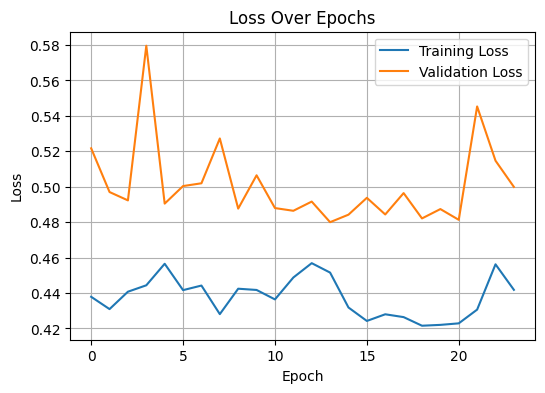

In [15]:
def plot_history(train_losses, val_losses):
    """学習履歴をプロット"""
    plt.figure(figsize=(6, 4))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# 学習履歴のプロット
plot_history(train_losses, val_losses)


## モデルの評価と結果

最後に、トレーニングされたモデルをテストデータセットに適用し、その性能を評価します。また、結果をヒートマップとして可視化します。

In [16]:
import random

def dice_coeff(pred, target):
    """Dice係数を計算"""
    smooth = 1.
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

# モデルを評価モードに設定
model.eval()
dice_scores = []

# テストデータに対する精度の計算
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        dice_scores.append(dice_coeff(outputs, labels))

# 平均Diceスコア
mean_dice = torch.mean(torch.tensor(dice_scores))
print(f'Mean Dice Score on Test Data: {mean_dice.item()}')

Mean Dice Score on Test Data: 0.5154168605804443


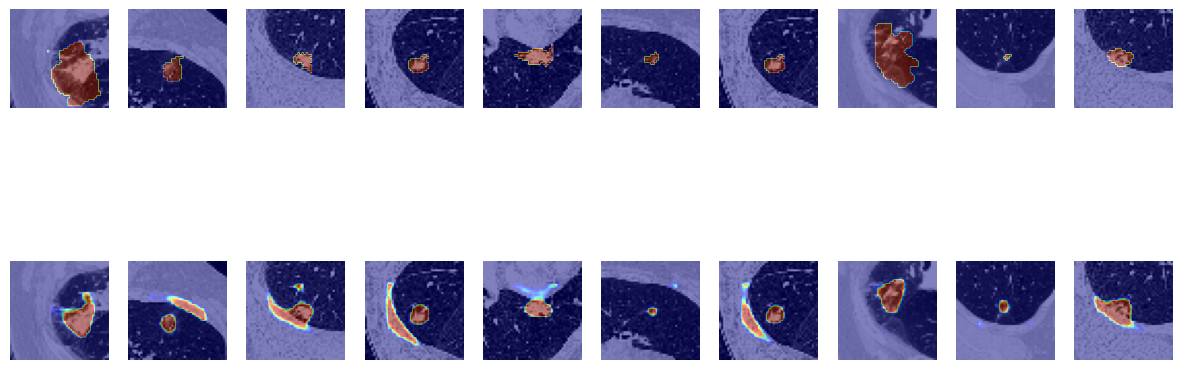

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# ランダムに10枚の画像を選択して可視化
indices = random.sample(range(len(test_dataset)), 10)
plt.figure(figsize=(15, 6))

for i, idx in enumerate(indices, 1):
    image, label = test_dataset[idx]
    image, label = image.to(device).unsqueeze(0), label.to(device).unsqueeze(0)
    pred = model(image).squeeze(0).cpu()

    # 1行目に実際のラベルを表示
    plt.subplot(2, 10, i)
    plt.imshow(image.cpu().squeeze(0)[0,...], cmap='gray')
    plt.imshow(label.cpu().squeeze(0)[0,...], cmap='jet', alpha=0.5)
    plt.axis('off')

    # 2行目に予測されたセグメンテーションマスクを表示
    plt.subplot(2, 10, i + 10)
    plt.imshow(image.cpu().squeeze(0)[0,...], cmap='gray')
    plt.imshow(pred.cpu().detach().numpy().squeeze(0), cmap='jet', alpha=0.5)
    plt.axis('off')

plt.show()


## 画像全体への適用

ここまでは CT 像から切り出したパッチへの処理を行ってきましたが、CT像全体に適用することを試してみます。

CT像は NIfTI（拡張子 nii.gz）という形式で保存してありますので、これを読み込んで、全体に対して処理します。その結果のファイルを PC へダウンロードして、画像とともに [3D Slicer](https://www.slicer.org/), [MITK Workbench](https://www.mitk.org/wiki/MITK), [ITK-SNAP](http://www.itksnap.org/pmwiki/pmwiki.php) などのソフトウェアで閲覧してください。

上記のパッチへの結果に比べて、画像全体への結果はおそらく期待にそぐわないものになると思います。

In [20]:
import nibabel as nib

# パッチサイズとステップサイズ
PATCH_SIZE = 48
STEP_SIZE = 32

# NIfTIファイルからデータを読み込む
nii = nib.load('/content/drive/MyDrive/education/data/msd/lung_2mm/nii/lung_001.nii.gz')
volume = nii.get_fdata()

# volumeを-1000から100の範囲にクリッピング
volume_clipped = np.clip(volume, -1000, 100)

# 正規化（0から1の範囲に変換）
volume_normalized = (volume_clipped + 1000) / 1100


# 出力ならびに、各画素にオーバーラップが行われた回数
output_volume = np.zeros_like(volume, dtype=np.float32)
count_volume = np.zeros_like(volume, dtype=np.uint8)
model.eval()

# スライディングウィンドウでボリューム全体を処理
with torch.no_grad():
    for z in range(volume_normalized.shape[2]):
        for y in range(0, volume_normalized.shape[1] - PATCH_SIZE + 1, STEP_SIZE):
            for x in range(0, volume_normalized.shape[0] - PATCH_SIZE + 1, STEP_SIZE):
                patch = volume_normalized[x:x+PATCH_SIZE, y:y+PATCH_SIZE, z]
                patch = torch.tensor(patch).unsqueeze(0).unsqueeze(0).to('cuda' if torch.cuda.is_available() else 'cpu', dtype=torch.float32)
                output = model(patch).squeeze().cpu().numpy()

                # 出力ボリュームとカウンターボリュームの更新
                output_volume[x:x+PATCH_SIZE, y:y+PATCH_SIZE, z] += output
                count_volume[x:x+PATCH_SIZE, y:y+PATCH_SIZE, z] += 1

# 各画素の平均値を計算（ゼロ除算を避ける）
output_volume /= np.maximum(count_volume, 1)

# 推論結果をNIfTIファイルとして保存
output_nii = nib.Nifti1Image(output_volume, nii.affine)
nib.save(output_nii, '/content/drive/MyDrive/education/data/msd/lung_2mm/nii/lung_001_out.nii.gz')
